# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [3]:
class GridWorld:
    ## Initialise starting data
    def __init__(self, height=8, width=8):
        # Set information about the gridworld
        self.height = height
        self.width = width
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [4]:
class QNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=4):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, state):
        # state is (x, y) → turn into tensor
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        if state.ndim == 1:
            state = state.unsqueeze(0)  # add batch dim
        return self.net(state)


In [5]:
# Test the QNetwork
test_net = QNetwork()
print(test_net)

# Try passing one state (x=4, y=2) to see Q-values
sample_state = (4, 2)
q_values = test_net(sample_state)
print("Q-values:", q_values)


QNetwork(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)
Q-values: tensor([[ 0.2843,  0.0338, -0.2044, -0.0926]], grad_fn=<AddmmBackward0>)


In [6]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, state, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [7]:
class Q_Agent():
    # Initialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict()  # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height):  # Loop through all possible grid spaces
            for y in range(environment.width):
                # Populate sub-dictionary with zero values for possible moves
                self.q_table[(x, y)] = {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, state, available_actions):
        """ε-greedy action selection"""
        if np.random.rand() < self.epsilon:
            action = np.random.choice(available_actions)   # Explore
        else:
            q_values = self.q_table[state]
            max_q = max([q_values[a] for a in available_actions])
            best_actions = [a for a in available_actions if q_values[a] == max_q]
            action = np.random.choice(best_actions)        # Exploit (break ties randomly)
        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        old_q = self.q_table[old_state][action]
        next_max_q = max(self.q_table[new_state].values())  # take max Q at new state

        # Q-learning update rule
        self.q_table[old_state][action] = old_q + self.alpha * (
            reward + self.gamma * next_max_q - old_q
        )


In [8]:
class DQNAgent:
    def __init__(self, environment, epsilon=0.1, alpha=0.01, gamma=0.99):
        self.environment = environment
        self.epsilon = epsilon      # exploration rate
        self.gamma = gamma          # discount factor

        # Q-network + optimizer
        self.q_net = QNetwork().to(torch.device("cpu"))
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=alpha)

        # Loss function
        self.criterion = nn.MSELoss()

        # Map action strings to indices
        self.action_map = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
        self.reverse_map = {v: k for k, v in self.action_map.items()}

    def choose_action(self, state, available_actions):
        # ε-greedy policy
        if np.random.rand() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32)
                q_values = self.q_net(state_tensor)
                action_idx = torch.argmax(q_values).item()
                return self.action_map[action_idx]

    def learn(self, old_state, reward, new_state, action):
        # Convert states to tensors
        old_state_tensor = torch.tensor(old_state, dtype=torch.float32)
        new_state_tensor = torch.tensor(new_state, dtype=torch.float32)

        # Q(s,a) prediction
        q_values = self.q_net(old_state_tensor)
        action_idx = self.reverse_map[action]
        q_value = q_values[0, action_idx]

        # Target: r + γ max_a' Q(s',a')
        with torch.no_grad():
            next_q_values = self.q_net(new_state_tensor)
            target = reward + self.gamma * torch.max(next_q_values)

        # Loss + backprop
        loss = self.criterion(q_value, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [9]:
# Test DQNAgent
env_test = GridWorld()
agent_test = DQNAgent(env_test, epsilon=0.5)  # 50% random, 50% greedy

print("Current position:", env_test.current_location)
available_actions = env_test.get_available_actions()
print("Available actions:", available_actions)

chosen_action = agent_test.choose_action(env_test.current_location, available_actions)
print("DQNAgent chose action:", chosen_action)


Current position: (4, 1)
Available actions: ['UP', 'DOWN', 'LEFT', 'RIGHT']
DQNAgent chose action: RIGHT


In [10]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    reward_per_episode = []

    for trial in range(trials):
        cumulative_reward = 0
        step = 0
        game_over = False

        while step < max_steps_per_episode and not game_over:
            old_state = environment.current_location
            action = agent.choose_action(old_state, environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            # Learning step (works for both Q_Agent and DQNAgent)
            if learn:
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL':
                environment.__init__()  # reset environment
                game_over = True

        reward_per_episode.append(cumulative_reward)

    return reward_per_episode


## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [11]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(env.current_location, available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 4)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 4)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

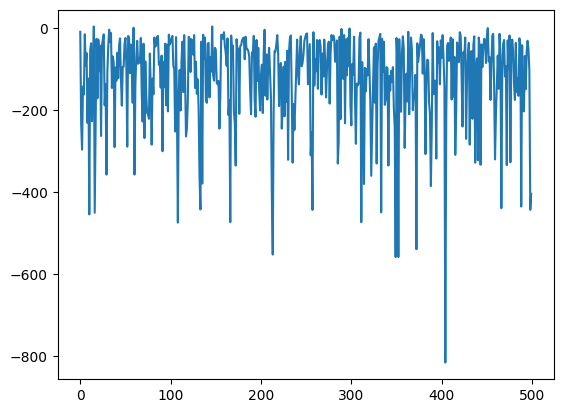

In [12]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

Training time on 8x8 grid: 0.10408830642700195 seconds
Training time on 20x20 grid: 0.1260542869567871 seconds


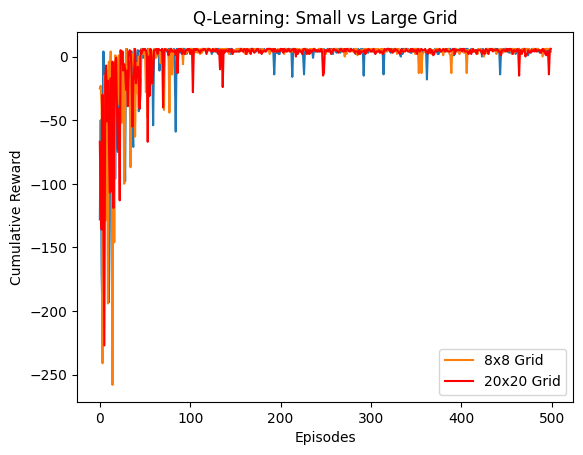

In [13]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)


import time

# --- Small Grid Experiment (8x8) ---
env_small = GridWorld(8, 8)
agent_small = Q_Agent(env_small)

start = time.time()
rewards_small = play(env_small, agent_small, trials=500, learn=True)
print("Training time on 8x8 grid:", time.time() - start, "seconds")

# --- Large Grid Experiment (20x20) ---
env_large = GridWorld(20, 20)
agent_large = Q_Agent(env_large)

start = time.time()
rewards_large = play(env_large, agent_large, trials=500, learn=True)
print("Training time on 20x20 grid:", time.time() - start, "seconds")

# --- Plot comparison ---
plt.plot(rewards_small, label="8x8 Grid")
plt.plot(rewards_large, label="20x20 Grid", color="red")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Q-Learning: Small vs Large Grid")
plt.legend()
plt.show()


Print the final Q-value table with nice formatting.

In [14]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.4
	DOWN
		-0.436833831
	LEFT
		-0.4
	RIGHT
		-0.11571534282643209
(0, 1)
	UP
		-0.2
	DOWN
		-0.281
	LEFT
		-0.21
	RIGHT
		6.472493783616838
(0, 2)
	UP
		3.095072694049669
	DOWN
		0.4294927972823376
	LEFT
		0.9741791410113181
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		0.1539
	DOWN
		-0.201
	LEFT
		9.99991664751582
	RIGHT
		-0.07348449737164825
(0, 5)
	UP
		-0.1
	DOWN
		-0.1
	LEFT
		2.886800820003249
	RIGHT
		-0.1
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.403619
	LEFT
		-0.15797453630328998
	RIGHT
		-0.30810000000000004
(0, 7)
	UP
		-0.4
	DOWN
		-0.43439
	LEFT
		-0.45561
	RIGHT
		-0.4
(1, 0)
	UP
		-0.6233341
	DOWN
		-0.6582781437320001
	LEFT
		-0.6
	RIGHT
		-0.557218209806039
(1, 1)
	UP
		1.5543378296247377
	DOWN
		-0.31810000000000005
	LEFT
		-0.39829000000000003
	RIGHT
		-0.36910000000000004
(1, 2)
	UP
		8.999999999999986
	DOWN
		1.744638959950726
	LEFT
		-0.24260617176438587
	RIGHT
		-6.12579511
(1, 3)
	UP
		0
	DOWN
		0
	LE

**DQN Training Run (small test)**

Train for 50 episodes to confirm the agent learns and the code runs without errors.

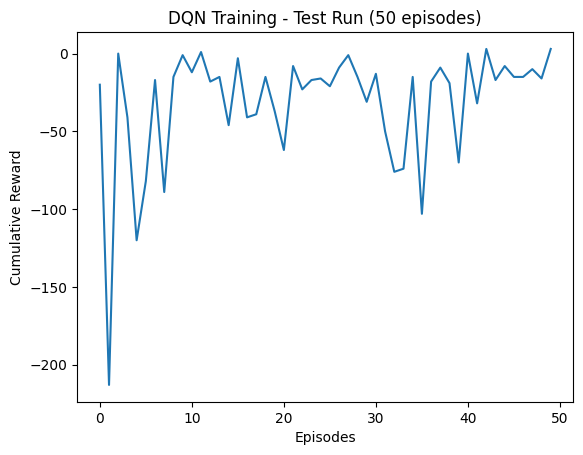

In [15]:
# Test small training run with DQNAgent
env = GridWorld()
dqn_agent = DQNAgent(env, epsilon=0.5, alpha=0.01, gamma=0.99)

rewards_dqn = play(env, dqn_agent, trials=50, learn=True)

# Plot rewards
import matplotlib.pyplot as plt
plt.plot(rewards_dqn)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("DQN Training - Test Run (50 episodes)")
plt.show()


Run DQN with ε = 0.1, 0.5, 0.9

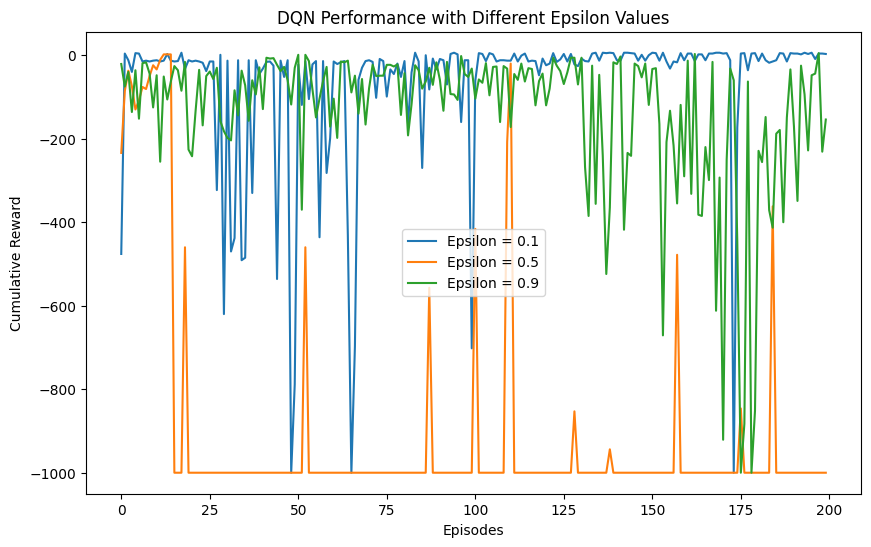

In [16]:
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    env = GridWorld()
    dqn_agent = DQNAgent(env, epsilon=eps, alpha=0.01, gamma=0.99)
    rewards = play(env, dqn_agent, trials=200, learn=True)  # 200 episodes
    results[eps] = rewards

# Plot comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
for eps, rewards in results.items():
    plt.plot(rewards, label=f"Epsilon = {eps}")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("DQN Performance with Different Epsilon Values")
plt.legend()
plt.show()
